In [1]:
import jetnet
from jetnet.datasets import JetNet
import numpy as np
import matplotlib.pyplot as plt
import gen_metrics
from tqdm import tqdm
import pandas as pd
from IPython.display import Markdown, display
import pickle
import plotting
from typing import OrderedDict
import mplhep as hep

plt.rcParams.update({"font.size": 16})


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os

plot_dir = "../plots/gapt_analysis/Nov15"
_ = os.system(f"mkdir -p {plot_dir}")

data_dir = "../saved_data/"
model = 162

In [4]:
loss_keys = {"fpd": "FPD", "fpnd": "FPND", "kpd": "KPD", "w1m": r"$W^M_1$"}

losses = {key: np.loadtxt(f"{data_dir}/{model}/{key}.txt") for key in loss_keys}
losses['fpnd'] = losses['fpnd'][:, np.newaxis]

In [5]:
losses["kpd"][:, 1] /= 2

## Correlation Plots

In [10]:
def correlation_plot(xkey, ykey, plot_range, scilimits=False):
    xlabel = loss_keys[xkey]
    ylabel = loss_keys[ykey]

    xlosses = losses[xkey][:, 0]
    ylosses = losses[ykey][:, 0]

    if ykey == "kpd":
        ylosses += losses[ykey][:, 1]

    plt.rcParams.update({"font.size": 24})
    plt.style.use(hep.style.CMS)

    fig = plt.figure(figsize=(12, 10))
    # h = plt.hist2d(xlosses, ylosses, bins=40, range=plot_range, cmap="jet")
    h = plt.hist2d(
        xlosses,
        ylosses,
        bins=(np.logspace(*np.log10(plot_range[0]), 40), np.logspace(*np.log10(plot_range[1]), 40)),
        range=plot_range,
        cmap="turbo",
    )
    # if scilimits:

    # if plot_range[0][1] < 0.1:
    #     plt.ticklabel_format(axis="x", scilimits=(0, 0), useMathText=True)
    # if plot_range[1][1] < 0.1:
    #     plt.ticklabel_format(axis="y", scilimits=(0, 0), useMathText=True)

    c = plt.colorbar(h[3])
    c.set_label("Batches")
    plt.xlabel(xlabel, loc="left")
    plt.ylabel(ylabel)
    plt.xscale("log")
    plt.yscale("log")
    plt.title(f"{xlabel} vs {ylabel} Correlation")
    plt.savefig(f"{plot_dir}/{model}_{xkey}v{ykey}.pdf", bbox_inches="tight")
    plt.show()


In [ ]:
correlation_plot("fpd", "fpnd", [[4e-4, 0.5], [1e-1, 100]])

In [ ]:
correlation_plot("fpd", "kpd", [[4e-4, 0.5], [5e-5, 0.1]], scilimits=True)


In [ ]:
correlation_plot("fpd", "w1m", [[4e-4, 0.5], [5e-4, 4e-2]], scilimits=True)


## Checking min values

In [253]:
print(np.min(losses['fpd'][:, 0]))
min_fpd = np.min(losses['fpd'][:, 0])
print(losses['fpd'][:, 1][np.argmin(losses['fpd'][:, 0])])
min_fpd_err = losses['fpd'][:, 1][np.argmin(losses['fpd'][:, 0])]
print(np.sum(losses['kpd'], axis=1)[np.argmin(losses['fpd'][:, 0])])
print(losses['w1m'][:, 0][np.argmin(losses['fpd'][:, 0])])
print(np.argmin(losses['fpd'][:, 0]) * 5)

0.00039494437002767104
1.6079706056339805e-05
0.00015920740407288216
0.0007647135795280332
1685


In [254]:
print(np.min(np.sum(losses['kpd'], axis=1)))
print(losses['kpd'][:, 1][np.argmin(losses['kpd'][:, 0])])
print(losses['fpd'][:, 0][np.argmin(losses['kpd'][:, 0])])
print(losses['w1m'][:, 0][np.argmin(losses['kpd'][:, 0])])
print(np.argmin(losses['kpd'][:, 0]) * 5)

8.88640662697693e-05
2.751509418614795e-06
0.22055455856711711
0.0010978168042935425
1125


In [255]:
print(np.min(losses['w1m'][:, 0]))
min_idx = np.argmin(losses['w1m'][:, 0])
print(min_idx * 5)
print(losses['fpd'][:, 0][min_idx])
print(losses['fpnd'][:, 0][min_idx])
print(np.sum(losses['kpd'], axis=1)[min_idx])

0.0006274817399960004
1740
0.0008508698333059454
1.9965005806967042
0.00030485624808473396


In [256]:
print(np.min(losses['fpnd'][:, 0]))
print(np.argmin(losses['fpnd'][:, 0]) * 5)
print(losses['fpd'][:, 0][np.argmin(losses['fpnd'][:, 0])])
print(losses['kpd'][:, 0][np.argmin(losses['fpnd'][:, 0])])

0.19972998007801834
865
0.0013954045144753918
0.0010260323282771356


In [257]:
print(np.sum(losses['fpd'][:, 0] < (min_fpd + 5 * min_fpd_err)))
selector = losses['fpd'][:, 0] < (min_fpd + 5 * min_fpd_err)
indices = np.where(selector)[0]
min_kpd_idx = indices[np.argmin(np.sum(losses['kpd'], axis=1)[indices])]
print(np.min(np.sum(losses['kpd'], axis=1)[indices]))
print(min_kpd_idx * 5)
min_fpnd_idx = indices[np.argmin(losses['fpnd'][indices])]
print(np.min(losses['fpnd'][indices]))
print(min_fpnd_idx * 5)
min_w1m_idx = indices[np.argmin(losses['w1m'][:, 0][indices])]
print(np.min(losses['w1m'][:, 0][indices]))
print(min_w1m_idx * 5)

1
0.00015920740407288216
1685
1.7353499552628477
1685
0.0007647135795280332
1685


In [258]:
print(np.sum(losses['w1m'][:, 0] < 0.001))
selector = losses['w1m'][:, 0] < 0.001
indices = np.where(selector)[0]
min_kpd_idx = indices[np.argmin(np.sum(losses['kpd'], axis=1)[indices])]
print(np.min(np.sum(losses['kpd'], axis=1)[indices]))
print(min_kpd_idx * 5)
min_fpnd_idx = indices[np.argmin(losses['fpnd'][indices])]
print(np.min(losses['fpnd'][indices]))
print(min_fpnd_idx * 5)
min_w1m_idx = indices[np.argmin(losses['fpd'][:, 0][indices])]
print(np.min(losses['fpd'][:, 0][indices]))
print(min_w1m_idx * 5)

23
0.00015920740407288216
1685
0.27452989351348833
920
0.00039494437002767104
1685


In [ ]:
plt.plot(np.arange(0, 4001, 5), losses['kpd'][:, 0] + losses['kpd'][:, 1])
plt.yscale('log')
plt.ylim([0, 1])

## Coverage Check

In [17]:
truth_jets_pf, _ = JetNet.getData(
    "t",
    data_dir="/Users/raghav/Documents/CERN/gen-models/MPGAN/datasets/",
    split_fraction=[0.7, 0.3, 0],
    particle_features=["etarel", "phirel", "ptrel"],
    jet_features=["pt", "eta", "mass", "num_particles"],
)

efps = jetnet.utils.efps(truth_jets_pf[:, :, :3], efpset_args=[("d<=", 4)])
real_efps = np.load(f"{data_dir}/g.npy")

In [ ]:
numb = 10
bs = 5000

means_ses = []
# means_ses = list(means_ses)
for i in tqdm(range(10, 100)):
    res = gen_metrics.multi_batch_evaluation_mmd(real_efps, efps, numb, bs, seed=i)
    means_ses.append([res[0], res[1]])

means_ses = np.array(means_ses)
np.save(f"{plot_dir}/means_ses_b{numb}_bs{bs}_means_ses.npy", means_ses)

plt.figure(figsize=(12, 12))
plt.errorbar(range(10), means_ses[:, 0], means_ses[:, 1], fmt="o")
plt.ylabel(r"FGD$_\infty$")
plt.ylim([-0.0001, 0.0001])
plt.xlabel("Seed")
plt.savefig(f"{plot_dir}/fgdinf_check_b{numb}_bs{bs}_vb_median_real.pdf")

In [250]:
np.sum((means_ses[:, 0] - means_ses[:, 1] < 0) * (means_ses[:, 0] + means_ses[:, 1] > 0))

74

In [ ]:
maxes = np.max(np.abs(real_efps), axis=0)
# maxes

In [ ]:
np.random.seed(2 + 2 * 1000)
rand1 = np.random.choice(len(real_efps), size=bs)
rand2 = np.random.choice(len(gen_efps), size=bs)

rand_sample1 = real_efps[rand1] / maxes
rand_sample2 = gen_efps[rand2] / maxes

gen_metrics.mmd_poly_quadratic_unbiased(rand_sample1, rand_sample2, normalise=False, degree=4)

0.059471909231144426

In [ ]:
efp_num = 8
_ = plt.hist(rand_sample1[:, efp_num], np.linspace(0, 10, 101), histtype='step', label="Real")
_ = plt.hist(rand_sample2[:, efp_num], np.linspace(0, 10, 101), histtype='step', label="Gen")
plt.yscale('log')
plt.xlabel(f"EFP {efp_num}")
# plt.xscale('log')
# plt.ylabel(r"$\overline{\mathrm{FGD}}_{\infty}^{+\sigma}$")
_ = plt.legend()

## Final Evaluation

In [30]:
real_jets, _ = JetNet.getData(
    "g",
    data_dir="/Users/raghav/Documents/CERN/gen-models/MPGAN/datasets/",
    split_fraction=[0.7, 0.3, 0],
    split="valid",
    particle_features=["etarel", "phirel", "ptrel"],
    jet_features=["pt", "eta", "mass", "num_particles"],
)

real_jets = real_jets[:50000]

In [31]:
gapt_epoch = np.argmin(losses['fpd'][:, 0])
real_efps = np.load(f"{data_dir}/g.npy")
mp_jets = np.load(f"{data_dir}/model_jets/mp_gen_jets.npy")
gapt_jets = np.load(f"{data_dir}/model_jets/gapt_gen_jets.npy")
gapt_efps = np.load(f"{data_dir}/model_jets/gapt_gen_efps.npy")
mp_efps = np.load(f"{data_dir}/model_jets/mp_gen_efps.npy")
# mp_efps = jetnet.utils.efps(mp_jets[:, :, :3], efpset_args=[("d<=", 4)])
# np.save(f"{data_dir}/model_jets/mp_gen_efps.npy", mp_efps)

In [32]:
real_masses = jetnet.utils.jet_features(real_jets)["mass"]
mp_masses = jetnet.utils.jet_features(mp_jets)["mass"]
gapt_masses = jetnet.utils.jet_features(gapt_jets)["mass"]

In [ ]:
mp_metrics = {
    "fpnd": 0.12,
    "w1m": gen_metrics.multi_batch_evaluation(real_masses, mp_masses, 5, 50000, gen_metrics.wasserstein1d, normalise=False, timing=False, seed=42),
    "kpd": gen_metrics.multi_batch_evaluation_mmd(real_efps, mp_efps, seed=42),
    "fpd": gen_metrics.one_over_n_extrapolation_repeated_measurements(real_efps, mp_efps, seed=42)[:2]
}

In [176]:
min_epoch = np.argmin(losses['fpd'][:, 0])
gapt_metrics = {key: losses[key][min_epoch] for key in loss_keys}
gapt_metrics["fpnd"] = gapt_metrics["fpnd"][0]
gapt_metrics["w1m"] = gen_metrics.multi_batch_evaluation(real_masses, gapt_masses, 5, 50000, gen_metrics.wasserstein1d, normalise=False, timing=False, seed=42)

In [264]:
truth_metrics = {
    "fpnd": 0.01,
    "w1m": [0.28e-3, 0.05e-3],
    "kpd": [-6e-6, 5e-6],
    "fpd": [1e-5, 2e-5],
}

In [265]:
table_metrics = {"Truth": truth_metrics, "MPGAN": mp_metrics, "GAPT": gapt_metrics}

def format_mean_std(mean_stds: np.ndarray):
    mean, sd = mean_stds

    if sd == 0:
        return f"${mean:.1f} \\pm 0.0$"

    """round mean and standard deviation to most significant digit of sd and apply latex formatting"""
    decimals = -int(np.floor(np.log10(sd)))
    decimals -= int((sd * 10**decimals) >= 9.5)

    if decimals < 0:
        ten_to = 10 ** (-decimals)
        if mean > ten_to:
            mean = ten_to * (mean // ten_to)
        else:
            mean_ten_to = 10 ** np.floor(np.log10(mean))
            mean = mean_ten_to * (mean // mean_ten_to)
        sd = ten_to * (sd // ten_to)
        decimals = 0

    if mean >= 1e3 and sd >= 1e3:
        mean = np.round(mean * 1e-3)
        sd = np.round(sd * 1e-3)
        return f"${mean:.{decimals}f}$k $\\pm {sd:.{decimals}f}$k"
    else:
        return f"${mean:.{decimals}f} \\pm {sd:.{decimals}f}$"


cols = ["fpd", "kpd", "w1m"]

rows = []

rows.append([""] + [loss_keys[col] + r" $\times 10^3$" for col in cols])

for label, row_metrics in table_metrics.items():
    row = [label]

    for col in cols:
        row.append(format_mean_std(np.array(row_metrics[col]) * 1e3))
    
    rows.append(row)

for i, col in enumerate(cols):
    if table_metrics["MPGAN"][col][0] < table_metrics["GAPT"][col][0]:
        bold_idx = 2
    else:
        bold_idx = 3

    rows[bold_idx][i + 1] = r"$\mathbf{" + rows[bold_idx][i + 1][1:-1] + r"}$"

textable = [
    " & ".join(row) + "\\\\\n" for row in rows
]

with open(f"{plot_dir}/model_scores.tex", "w") as f:
    f.writelines(textable)


results = pd.DataFrame(
    rows[1:], columns=rows[0]
)

display(Markdown(results.to_markdown()))


|    |       | FPD $\times 10^3$        | KPD $\times 10^3$           | $W^M_1$ $\times 10^3$    |
|---:|:------|:-------------------------|:----------------------------|:-------------------------|
|  0 | Truth | $0.01 \pm 0.02$          | $-0.006 \pm 0.005$          | $0.28 \pm 0.05$          |
|  1 | MPGAN | $\mathbf{0.20 \pm 0.02}$ | $\mathbf{-0.001 \pm 0.004}$ | $\mathbf{0.54 \pm 0.06}$ |
|  2 | GAPT  | $0.39 \pm 0.02$          | $0.154 \pm 0.002$           | $0.56 \pm 0.08$          |

In [33]:
jets_dict = {"Real": real_jets[:50000], "MPGAN": mp_jets, "GAPT": gapt_jets}
efps_dict = {"Real": real_efps, "MPGAN": mp_efps, "GAPT": gapt_efps}
masses_dict = {"Real": real_masses, "MPGAN": mp_masses, "GAPT": gapt_masses}

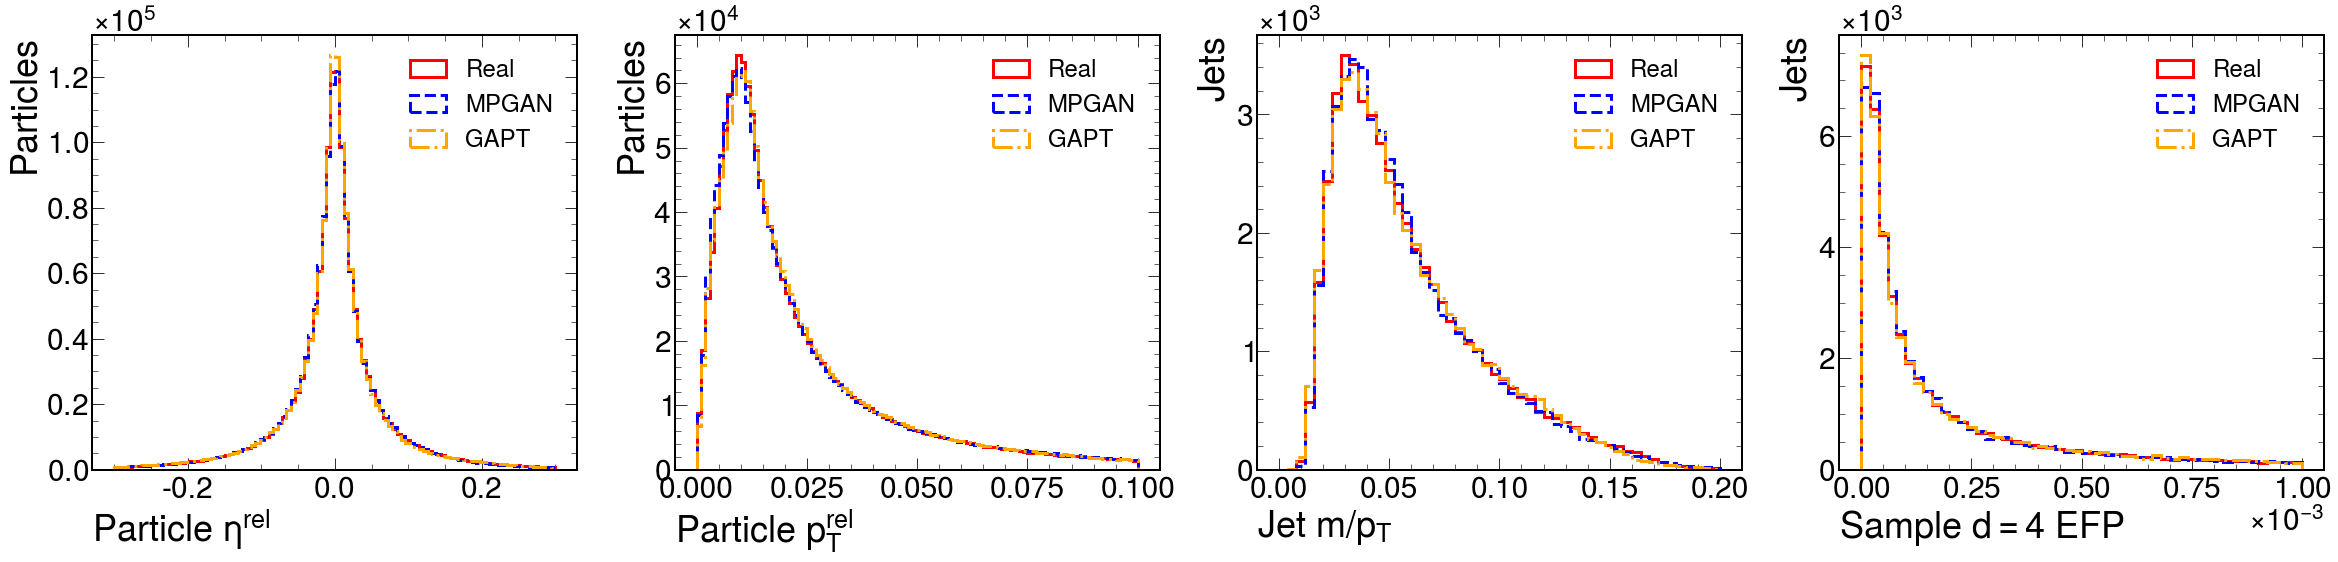

In [44]:
plt.style.use(hep.style.CMS)
plt.rcParams.update({"font.size": 36})

line_opts = {
    "Real": {"color": "red", "linewidth": 3, "linestyle": "solid"},
    "MPGAN": {"color": "blue", "linewidth": 3, "linestyle": "dashed"},
    "GAPT": {"color": "orange", "linewidth": 3, "linestyle": "dashdot"},
}

fig, axes = plt.subplots(1, 4, figsize=(40, 8))

pbins = [np.linspace(-0.3, 0.3, 101), np.linspace(0, 0.1, 101)]
mbins = np.linspace(0, 0.2, 51)
efpbins = np.linspace(0, 0.001, 51)
# ylims = [1.5e5, 1e5, 1e4, 3e4]

xlabels = [
    r"Particle $\eta^{\mathrm{rel}}$",
    r"Particle $p_T^{\mathrm{rel}}$",
    r"Jet $m/p_T$",
    r"Sample $d=4$ EFP",
]

ylabels = ["Particles", "Particles", "Jets", "Jets"]


for key, opts in line_opts.items():
    jets = jets_dict[key]

    # remove zero-padded particles
    mask = np.linalg.norm(jets, axis=2) != 0
    parts = jets[mask]

    _ = axes[0].hist(parts[:, 0], pbins[0], histtype="step", label=key, **opts)
    _ = axes[1].hist(parts[:, 2], pbins[1], histtype="step", label=key, **opts)
    _ = axes[2].hist(masses_dict[key], mbins, histtype="step", label=key, **opts)
    _ = axes[3].hist(efps_dict[key][:, 25], efpbins, histtype="step", label=key, **opts)


for i in range(4):
    axes[i].set_xlabel(xlabels[i], loc="left")
    axes[i].set_ylabel(ylabels[i])
    # axes[i].set_ylim(0, ylim)
    axes[i].legend(loc=1, prop={"size": 24}, fancybox=True)
    axes[i].ticklabel_format(axis="y", scilimits=(0, 0), useMathText=True)

axes[3].ticklabel_format(axis="x", scilimits=(0, 0), useMathText=True)

# plt.tight_layout(pad=0.5)
plt.savefig(f"{plot_dir}/feature_distributions.pdf", bbox_inches="tight")
plt.show()
